### Import Libraries

In [47]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split, desc
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

from embedders.my_sentence_transformer import MySentenceTransformer
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.stats import spearmanr

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from nlp_preprocessor import text_preprocessor
from collections import Counter

#### Load .env which contains OpenA API Key

In [48]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [49]:
from openai import OpenAI
client = OpenAI()

#### Create Spark Session

In [50]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

#### Read in reviews data

In [51]:
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [52]:
reviews_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|If you decide to ...|2018-07-07 22:09:11|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|I've taken a lot ...|2012-01-03 15:28:18|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|Family diner. Had...|2014-02-05 20:30:30|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|Wow!  Yummy, diff...|2015-01-04 00:01:03|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|Cu

#### Select only needed columns

In [53]:
reviews_df = reviews_df.select('review_id', 'business_id', 'text', 'date')

#### Read in business data

In [54]:
# Read business data
businesses_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)

In [65]:
businesses_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### Return business id, given business name
Get 'business_id' with highest review count, given business name. We need 'business_id' to filter reviews using id.

In [55]:
# Get reviews of highest review count business
businesses_found = businesses_df[businesses_df['name'].str.lower() == 'acme oyster house']

# Open businesses found
open_businesses_found = businesses_found[businesses_found.is_open == 1].sort_values('review_count', ascending=False)

business_id = open_businesses_found.iloc[0].business_id

In [56]:
business_id

'_ab50qdWOk0DdB6XOrBitw'

#### Filter reviews given business id
I only need reviews from a single business in downstream processes. Filter reviews df using business_id

In [57]:
# Retrieve reviews for using business id
business_reviews = reviews_df.filter(col('business_id') == business_id)

In [58]:
business_reviews_df = business_reviews.toPandas()

In [59]:
business_reviews_df.head()

,review_id,business_id,text,date
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20


In [60]:
# Stop the SparkSession
spark.stop()

#### Text Preprocessing
- Expand Contractions
- *Remove unwanted characters(ignore, not sure about punctuation yet)
- Replace accented characters
- Remove HTML tags
- Collapse whitespace
- Lower case (Standardize the case)

In [61]:
business_reviews_df['text_cleaned'] = business_reviews_df.text.apply(text_preprocessor)

#### Extract year for visualizing review counts trends over years
We want to check what years had highest number of reviews for this business.

In [79]:
# extract year from date
business_reviews_df['year'] = pd.to_datetime(business_reviews_df.date).dt.year

#### Feature Engineering

High-level information:
- Text length(preprocessed text; num of chars)
- Word counts(Count Vectorizer/Tf-Idf/N-grams)
- Average word length

In [69]:
business_reviews_df['char_count'] = business_reviews_df.text_cleaned.str.len()
business_reviews_df['word_count'] = business_reviews_df.text_cleaned.str.split().str.len()
business_reviews_df['avg_word_length'] = business_reviews_df['char_count']/business_reviews_df['word_count']

In [70]:
business_reviews_df

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,review_id,business_id,text,date,text_cleaned,char_count,word_count,avg_word_length
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,557,107,5.205607
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,425,82,5.182927
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,530,97,5.463918
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,193,40,4.825000
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",1277,230,5.552174
...,...,...,...,...,...,...,...,...
7668,bax2r1CzIbGAFl3s45V2mg,_ab50qdWOk0DdB6XOrBitw,Came here about 2pm on a rainy Sunday afternoo...,2013-12-27 15:36:07,came here about 2pm on a rainy sunday afternoo...,768,144,5.333333
7669,d5LAa5CvdLyyze89810DWQ,_ab50qdWOk0DdB6XOrBitw,"Once I walked near this place, I knew that I h...",2018-07-01 04:36:45,"once i walked near this place, i knew that i h...",326,70,4.657143
7670,z-tXUBHlqMtnHbta6rFNDA,_ab50qdWOk0DdB6XOrBitw,Tip- get there just a little early (like right...,2019-07-27 15:26:25,tip- get there just a little early (like right...,644,126,5.111111
7671,BSkhHEd4bKwuzy4gbU8NFA,_ab50qdWOk0DdB6XOrBitw,All I can say about this place is it is one of...,2015-05-20 23:05:09,all i can say about this place is it is one of...,555,108,5.138889


#### Content-based features
- Tf-Idf

In [77]:
tv = TfidfVectorizer(
    stop_words="english",
    max_features=8000,
    min_df=0.2,
    max_df=0.9
)

tfidf_matrix = tv.fit_transform(business_reviews_df["text_cleaned"])
tf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tv.get_feature_names_out()).add_prefix('TFIDF_')

In [78]:
tf_df.iloc[0].sort_values(ascending=False)

TFIDF_best           0.582591
TFIDF_wait           0.479278
TFIDF_oysters        0.413473
TFIDF_acme           0.283809
TFIDF_great          0.252700
TFIDF_chargrilled    0.244760
TFIDF_place          0.235814
TFIDF_oyster         0.000000
TFIDF_time           0.000000
TFIDF_service        0.000000
TFIDF_raw            0.000000
TFIDF_po             0.000000
TFIDF_new            0.000000
TFIDF_orleans        0.000000
TFIDF_line           0.000000
TFIDF_just           0.000000
TFIDF_good           0.000000
TFIDF_fried          0.000000
TFIDF_food           0.000000
TFIDF_delicious      0.000000
TFIDF_worth          0.000000
Name: 0, dtype: float64

#### Lemmatize pre-processed reviews (spacy)
We tokenize each review into words, and keep words that carry semantic meaning. We normalize these words into their base form to eliminate redundant meaning and sort of prune our vocabulary.

In [82]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize(preprocessed_text):
    doc = nlp(preprocessed_text)
    return " ".join([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])

In [83]:
business_reviews_df["lemmas"] = business_reviews_df["text_cleaned"].apply(lemmatize)

In [23]:
svd = TruncatedSVD(n_components=2, random_state=42)
tfidf_2d = svd.fit_transform(tfidf_matrix)

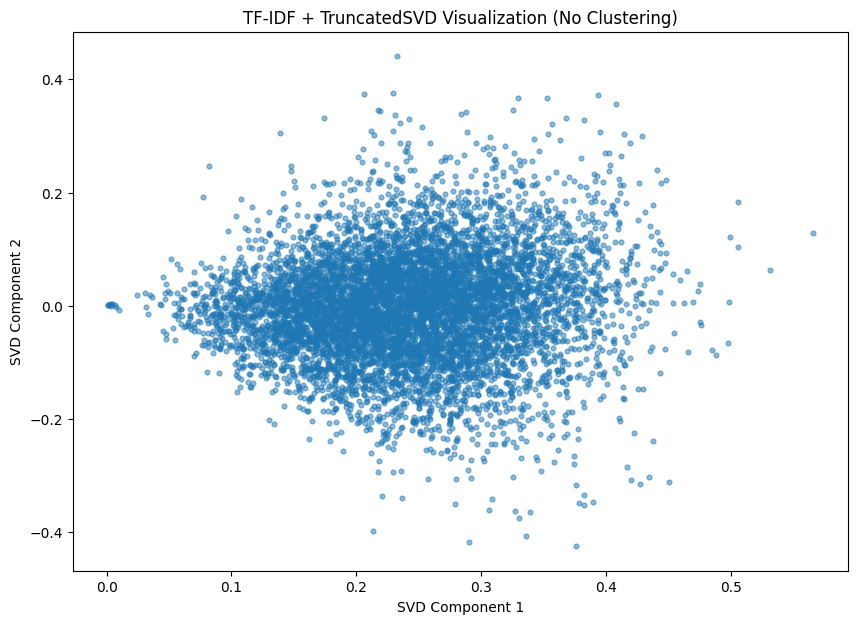

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], alpha=0.5, s=12)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("TF-IDF + TruncatedSVD Visualization (No Clustering)")
plt.show()

In [86]:
business_reviews_per_year = business_reviews_df.year.value_counts().sort_index()
business_reviews_per_year = business_reviews_per_year.reset_index()
business_reviews_per_year.columns = ['year', 'num_reviews']
business_reviews_per_year

,year,num_reviews
0,2006,9
1,2007,15
2,2008,59
3,2009,173
4,2010,240
5,2011,347
6,2012,367
7,2013,535
8,2014,631
9,2015,802


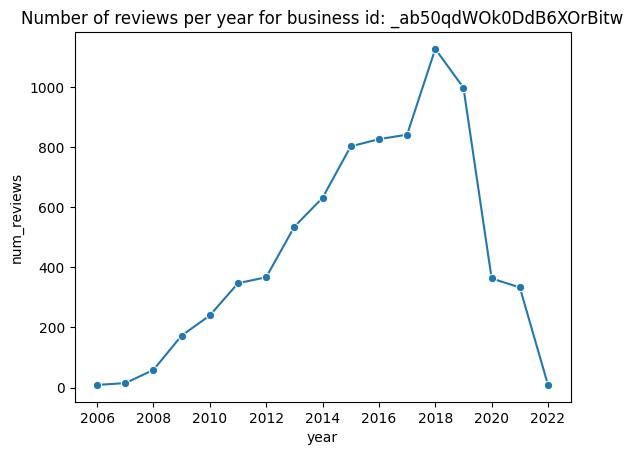

In [88]:
sns.lineplot(x='year', y='num_reviews', marker='o', data=business_reviews_per_year)
plt.title(f"Number of reviews per year for business id: {business_id}")
plt.show()

### Embeddings

In [89]:
my_mpnet_transformer = MySentenceTransformer(model_name='paraphrase-MiniLM-L3-v2')

In [91]:
embs = my_mpnet_transformer.transform_sentences(business_reviews_df.text_cleaned)

#### Normalize embeddings

In [92]:
normalized_embs = normalize(embs)

In [94]:
business_reviews_df['embeddings'] = normalized_embs.tolist()

### Finding best k(number fo clusters to use)

## Clustering Evaluation Metric Summary

| Metric | One-Sentence Explanation |
|--------|---------------------------|
| **Silhouette Score** | Measures how well each point fits within its assigned cluster by comparing its cohesion to its separation from other clusters (higher = better). |
| **Average Intra-Cluster Cosine Similarity** | Computes the average semantic similarity between points within the same cluster to measure theme tightness (higher = more coherent clusters). |
| **Inter-Centroid Cosine Similarity** | Measures similarity between cluster centroids to show how distinct clusters are from one another (lower = better separation). |


In [95]:
def evaluate_k_range(embeddings, k_values, use_cosine_silhouette=True):
    results = []

    for k in k_values:
        print(f"Evaluating k={k}...")

        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        centroids = kmeans.cluster_centers_

        # Global score
        # Silhouette Score (cosine recommended for embeddings)
        if use_cosine_silhouette:
            dist_matrix = cosine_distances(embeddings)
            sil = silhouette_score(dist_matrix, labels, metric="precomputed")
        else:
            sil = silhouette_score(embeddings, labels)

        # Per cluster cohesion
        intra_cosines = []
        for cluster_id in range(k):
            cluster_embs = embeddings[labels == cluster_id]

            if len(cluster_embs) > 1:
                cos_sim = cosine_similarity(cluster_embs)
                avg_intra = np.mean(cos_sim[np.triu_indices_from(cos_sim, k=1)])
            else:
                avg_intra = np.nan

            intra_cosines.append(avg_intra)

        avg_intra_cluster_cos = np.nanmean(intra_cosines)

        # Inter-cluster separation
        centroid_cos = cosine_similarity(centroids)
        # mask diagonal 1.0s
        separation = np.nanmean(
            centroid_cos[~np.eye(centroid_cos.shape[0], dtype=bool)]
        )

        results.append({
            "k": k,
            "silhouette": sil,
            "avg_intra_cosine": avg_intra_cluster_cos,
            "inter_centroid_cosine": separation
        })

    return pd.DataFrame(results)


In [97]:
k_values = range(2, 13)   # test k=2 through 12
results_df = evaluate_k_range(normalized_embs, k_values)
results_df

Evaluating k=2...
Evaluating k=3...
Evaluating k=4...
Evaluating k=5...
Evaluating k=6...
Evaluating k=7...
Evaluating k=8...
Evaluating k=9...
Evaluating k=10...
Evaluating k=11...
Evaluating k=12...


,k,silhouette,avg_intra_cosine,inter_centroid_cosine
0,2,0.116959,0.432641,0.873916
1,3,0.048547,0.451381,0.864427
2,4,0.049460,0.463206,0.851744
3,5,0.044084,0.464439,0.834386
4,6,0.044441,0.475248,0.827332
5,7,0.038759,0.482991,0.824403
6,8,0.036654,0.489689,0.818991
7,9,0.037363,0.485532,0.807300
8,10,0.035967,0.487630,0.798873
9,11,0.035014,0.492378,0.801500


In [118]:
# Assign a rank to each k, assign weights to each metric
results_df["score"] = (
    1 * results_df["silhouette"].rank(ascending=False) +
    2 * results_df["avg_intra_cosine"].rank(ascending=False) +
    3 * results_df["inter_centroid_cosine"].rank(ascending=True)
)

In [119]:
best_k = int(results_df.sort_values("score", ascending=False).iloc[0]["k"])
best_k

4

#### Using best_k

In [120]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(normalized_embs)

In [121]:
top_business_reviews_df['cluster_id'] = labels

In [122]:
top_business_reviews_df.head()

,review_id,business_id,stars,text,date,lemmas,year,embeddings,cluster_id
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,place amazing oyster well bloody mary stay nol...,2016,"[0.04403141140937805, 0.0623617023229599, 0.09...",1
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh try idea line definitely worth oyster amazi...,2016,"[-0.03591486066579819, -0.03511025756597519, 0...",1
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,fried seafood extremely hot nice taste add sof...,2018,"[-0.027192307636141777, 0.013716382905840874, ...",2
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,love place wish stay long visit food awesome d...,2013,"[-0.0233197920024395, 0.018473675474524498, 0....",0
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,love chargrilled oyster mean seriously tasty c...,2010,"[-0.010121154598891735, 0.05641814321279526, 0...",1


### Compute Per-Cluster Summary Stats

For each cluster:
- size
- average intra-cluster cosine
- centroid similarity
- top terms (TF-IDF)
- representative examples

#### Size(counts in cluster)

In [123]:
top_business_reviews_df.cluster_id.value_counts().sort_values(ascending=False)

cluster_id
1    2769
2    2067
3    1591
0    1246
Name: count, dtype: int64

#### Intra-cluster cosine

In [124]:
# Average intra cluster cosine similarity score
def avg_intra_cos(cluster_embs):
    sim = cosine_similarity(cluster_embs)
    return sim[np.triu_indices_from(sim, 1)].mean()

In [125]:
cluster_intra_cos = {
    cid: avg_intra_cos(normalized_embs[labels == cid]) for cid in range(best_k)
}

In [126]:
cluster_intra_cos

{0: 0.49447247, 1: 0.5213294, 2: 0.4792386, 3: 0.36624938}

#### Centroid similarity
Tells us how unique our clusters are, low similarity is the goal

In [127]:
### Centroid similarity
centroids = np.vstack([normalized_embs[labels == c].mean(axis=0) for c in range(best_k)])
center_sims = cosine_similarity(centroids)

nearest_centroid_similarity = {}
nearest_to = {}

for i, c in enumerate(range(best_k)):
    row = center_sims[i]

    # remove diagonal line 
    masked = np.delete(row, i)    
    nearest_centroid_similarity[c] = masked.max()
    
    # map back to original cluster index
    nearest_idx = np.argmax(masked)
    
    nearest_cluster = nearest_idx if nearest_idx < i else nearest_idx + 1
    nearest_to[c] = nearest_cluster

In [128]:
nearest_centroid_similarity

{0: 0.87697196, 1: 0.9175215, 2: 0.9175215, 3: 0.8386335}

In [129]:
nearest_to

{0: 1, 1: 2, 2: 1, 3: 0}

#### Top terms(TF-IDF)

#### i. "Learn the noise"
Identify and remove generic terms that appear in 80% of clusters

In [87]:
# Count unigrams across all documents
all_words = " ".join(top_business_reviews_df.lemmas).split()
freq = Counter(all_words)

# How many documents each word appears in
doc_freq = {}
for word in freq:
    doc_freq[word] = sum(top_business_reviews_df.lemmas.str.contains(fr"\b{word}\b"))

# remove overly common terms
noisy_unigrams = {w for w, df in doc_freq.items() if df > 0.6 * len(top_business_reviews_df)}

# remove very short tokens
noisy_unigrams = {w for w in noisy_unigrams if len(w) > 2}

print(len(noisy_unigrams), noisy_unigrams)

1 {'oyster'}


In [91]:
# Add these generic terms to stop_words list
review_stopwords = {
    'good', 'great', 'nice', 'amazing', 'delicious', 'tasty',
    'food', 'place', 'spot', 'service', 'wait', 'line', 'time',
    'come', 'order', 'ordered', 'got', 'make', 'made', 'try',
    'eat', 'go', 'went', 'get', 'take', 'give', 'ask', 'staff',
    'people', 'customer', 'experience', 'really', 'pretty',
    'little', 'bit', 'lot', 'thing', 'things'
}

base_stopwords = set(TfidfVectorizer(stop_words="english").get_stop_words())
full_stopwords = base_stopwords.union(noisy_unigrams, review_stopwords)

#### ii. Extract meaningful terms

In [92]:
tfidf = TfidfVectorizer(stop_words=list(full_stopwords), max_df=0.80, min_df=1, max_features=3000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(top_business_reviews_df.lemmas)
top_terms_by_cluster = {}

for cid in range(best_k):
    idx = np.where(labels == cid)[0]
    sub_tfidf = tfidf_matrix[idx].mean(axis=0).A1
    top_idx = sub_tfidf.argsort()[::-1][:10]
    top_terms_by_cluster[cid] = [tfidf.get_feature_names_out()[i] for i in top_idx]

In [93]:
for cid, terms in top_terms_by_cluster.items():
    print(f"cluster {cid} top terms: {terms}")

cluster 0 top terms: ['worth', 'long', 'grill', 'bar', 'love', 'fresh', 'raw', 'like', 'friendly', 'fast']
cluster 1 top terms: ['fry', 'shrimp', 'gumbo', 'fried', 'seafood', 'crab', 'jambalaya', 'like', 'crawfish', 'fish']
cluster 2 top terms: ['grill', 'charbroile', 'raw', 'char', 'char grill', 'dozen', 'like', 'fresh', 'seafood', 'crab']
cluster 3 top terms: ['acme', 'house', 'acme house', 'nola', 'new', 'new orleans', 'orleans', 'visit', 'like', 'seafood']
cluster 4 top terms: ['orleans', 'new orleans', 'new', 'visit', 'acme', 'visit new', 'worth', 'restaurant', 'chargrilled', 'grill']
cluster 5 top terms: ['bar', 'seat', 'minute', 'dozen', 'long', 'chargrilled', 'like', 'raw', 'sit', 'gumbo']
cluster 6 top terms: ['long', 'worth', 'table', 'restaurant', 'drink', 'seat', 'nola', 'bar', 'like', 'sit']
cluster 7 top terms: ['chargrilled', 'chargrille', 'worth', 'gumbo', 'dozen', 'raw', 'crawfish', 'seafood', 'love', 'nola']
cluster 8 top terms: ['boy', 'po', 'po boy', 'shrimp', 'shri

#### Visualizing

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


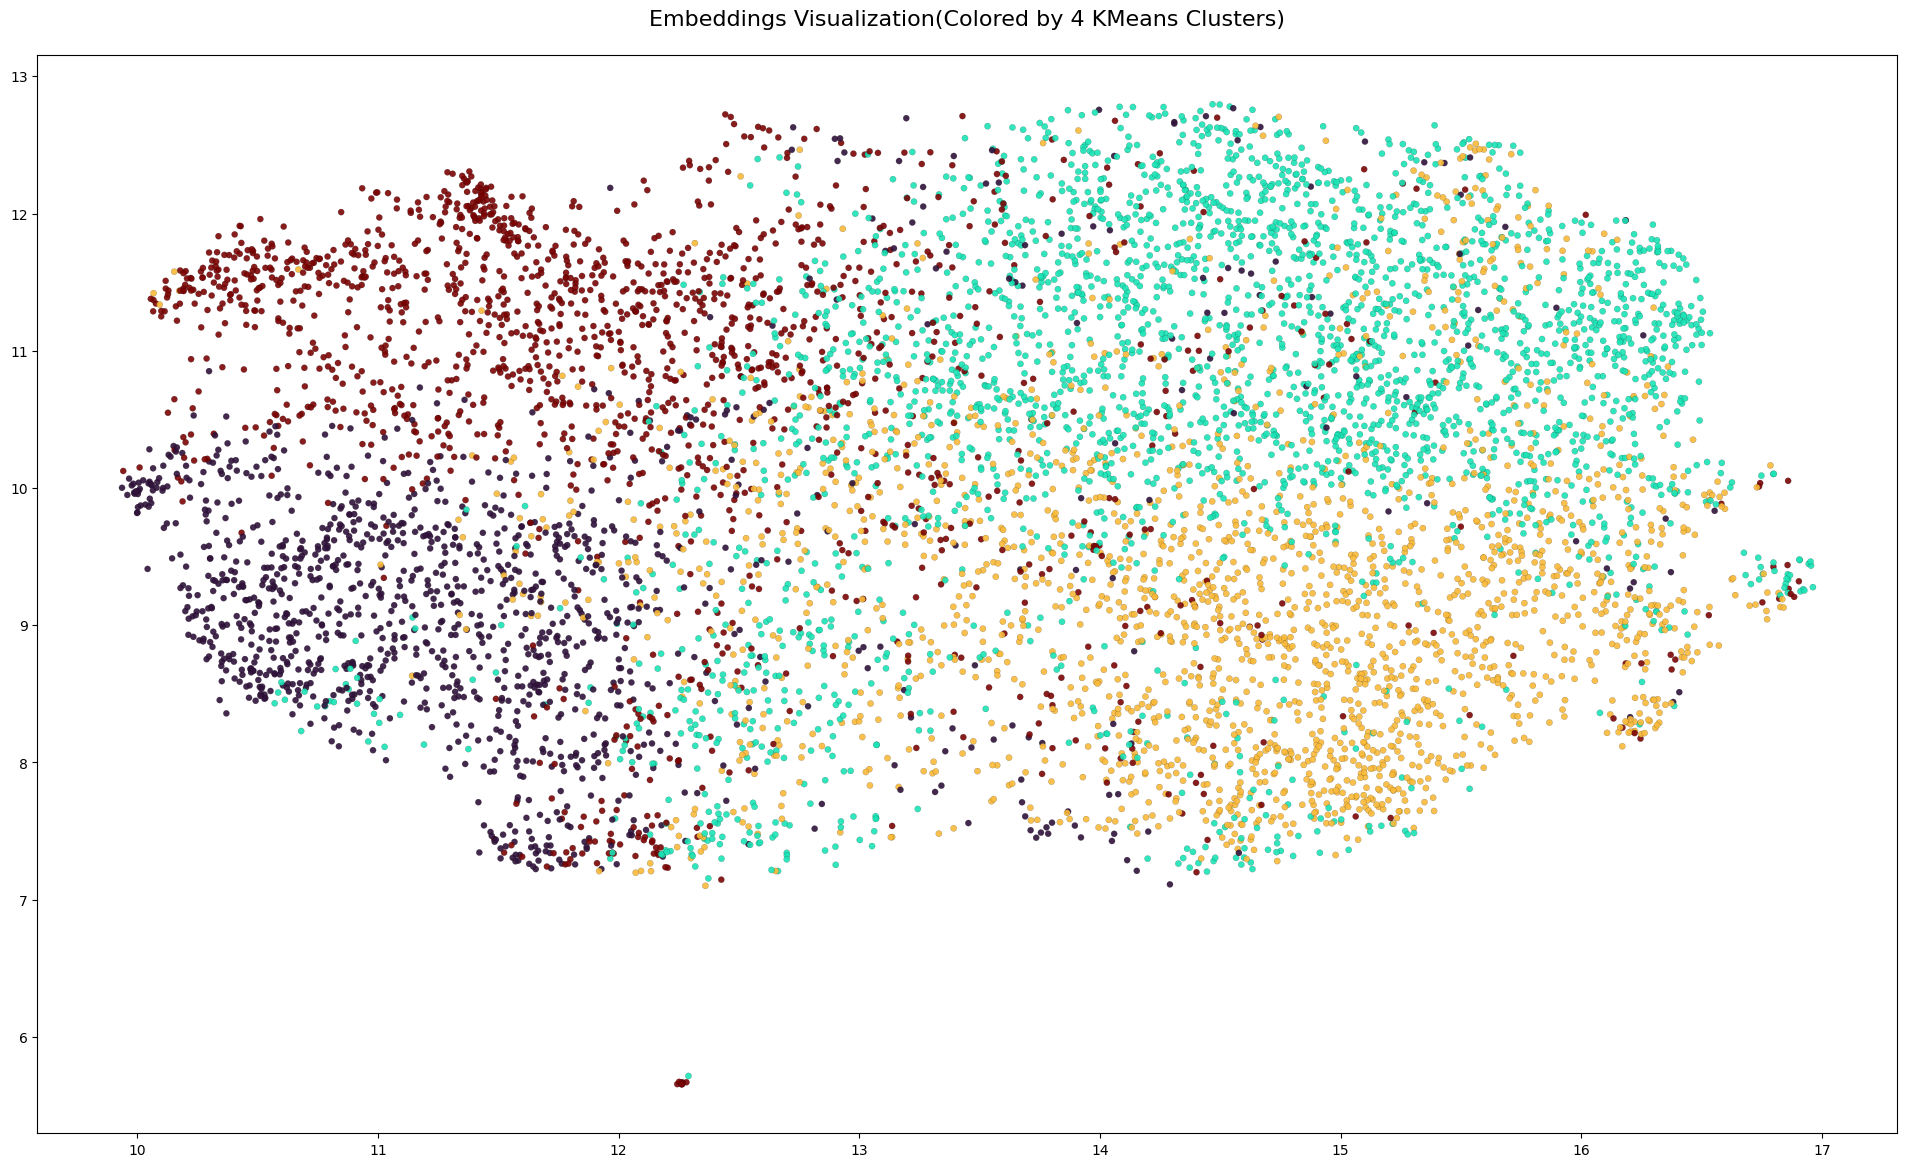

In [130]:
# UMAP visualization with cluster coloring
reducer = UMAP(n_components=2, random_state=42)

labels = top_business_reviews_df.cluster_id
    
# Reduce to 2D
emb_2d = reducer.fit_transform(np.vstack(top_business_reviews_df.embeddings.values))

plt.figure(figsize=(24, 14))

# Plot clusters
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=20,
    cmap='turbo',
    alpha=0.9,
    edgecolor='k',
    linewidth=0.1
)

plt.title(f"Embeddings Visualization(Colored by {best_k} KMeans Clusters)", fontsize=16, y=1.02)
plt.show()


#### Cluster Interpretability
Turn clusters into themes

#### i. Pull most representative reviews of a cluster
These are cluster centroid example reviews

In [131]:
def get_centroid_examples(df, emb_array, kmeans, cluster_id, top_n=3):
    # Identify which rows belong to this cluster
    idx = np.where(df.cluster_id.values == cluster_id)[0]

    # Get their embeddings
    cluster_embs = emb_array[idx]

    # Get the centroid for this cluster
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)

    # Compute cosine similarity to centroid
    sims = cosine_similarity(cluster_embs, centroid).flatten()

    # Sort by similarity (descending)
    top_indices = sims.argsort()[::-1][:top_n]

    # Map back to original DF indices
    original_indices = idx[top_indices]

    # Return the actual review texts
    return df.iloc[original_indices][["text", "stars"]]

In [132]:
centroid_examples = {}

for cid in range(best_k):
    centroid_examples[cid] = get_centroid_examples(
        top_business_reviews_df,
        normalized_embs,
        kmeans,
        cid
    )

In [133]:
centroid_examples

{0:                                                    text  stars
 2237  This place is probably one of the best restaur...    5.0
 2749  On my stay here in New Orleans this was defini...    4.0
 1043  My wife and I enjoyed the restaurant so much t...    5.0,
 1:                                                    text  stars
 1435  The best oysters I have ever tried, raw and th...    5.0
 5059  Not a fan of raw oysters so they recommended t...    5.0
 732   The oysters lived up to the hype! I split the ...    4.0,
 2:                                                    text  stars
 7537  We got the Shrimp po boy, and char grilled oys...    5.0
 5256  Very good food. The chargrilled oysters were d...    5.0
 4015  Mmm~~ My friends and I were most definitely no...    5.0,
 3:                                                    text  stars
 3502  This restaurant really is as good as everyone ...    5.0
 5774  Wonderful Food and Amazing Service!!! Decided ...    5.0
 7044  Came here on a Sun

#### ii. Sentiment per cluster

In [134]:
cluster_sentiment = {}

for cid in range(best_k):
    stars = top_business_reviews_df[top_business_reviews_df.cluster_id == cid]["stars"]
    
    cluster_sentiment[cid] = {
        "count": len(stars),
        "avg_rating": stars.mean(),
        "pct_positive": (stars >= 4).mean(),
        "pct_negative": (stars <= 2).mean(),
        "pct_neutral": ((stars > 2) & (stars < 4)).mean(),
    }

cluster_sentiment

{0: {'count': 1246,
  'avg_rating': 4.354735152487962,
  'pct_positive': 0.8539325842696629,
  'pct_negative': 0.05537720706260032,
  'pct_neutral': 0.09069020866773676},
 1: {'count': 2769,
  'avg_rating': 4.310220296135789,
  'pct_positive': 0.8490429758035392,
  'pct_negative': 0.04947634525099314,
  'pct_neutral': 0.10148067894546768},
 2: {'count': 2067,
  'avg_rating': 4.048379293662313,
  'pct_positive': 0.7421383647798742,
  'pct_negative': 0.10111272375423319,
  'pct_neutral': 0.1567489114658926},
 3: {'count': 1591,
  'avg_rating': 3.7221873035826523,
  'pct_positive': 0.6492771841609051,
  'pct_negative': 0.19296040226272784,
  'pct_neutral': 0.15776241357636706}}

#### Generate themes using OpenAI API

In [106]:
from textwrap import dedent

def generate_theme(cid, terms, examples, sentiment):
    examples_text = "\n---\n".join(
        [f"({e['stars']}★) {e['text']}" for e in examples]
    )

    prompt = dedent(f"""
    You are analyzing Yelp review clusters. 

    Cluster ID: {cid}

    Top Terms:
    {terms}

    Representative Reviews:
    {examples_text}

    Sentiment:
    - Average rating: {sentiment['avg_rating']:.2f}
    - Positive: {sentiment['pct_positive']:.2%}
    - Neutral: {sentiment['pct_neutral']:.2%}
    - Negative: {sentiment['pct_negative']:.2%}

    Produce:
    1. Theme Name (3–5 words)
    2. Short summary of what this cluster is about
    3. What customers like
    4. What customers dislike
    5. Why this cluster matters for the business

    Keep it concise and business-friendly.
    """)

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You are an expert in customer experience analytics."},
                  {"role": "user", "content": prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content

In [107]:
cluster_themes = {}

for cid in range(best_k):
    examples = centroid_examples[cid][["text", "stars"]].to_dict(orient="records")
    cluster_themes[cid] = generate_theme(
        cid,
        top_terms_by_cluster[cid],
        examples,
        cluster_sentiment[cid]
    )

cluster_themes

{0: '1. **Theme Name**: Worth the Wait for Fresh Seafood\n\n2. **Short Summary**: This cluster highlights customer experiences centered around the quality and freshness of seafood, particularly oysters, and the overall positive dining experience despite long wait times.\n\n3. **What Customers Like**: Customers appreciate the freshness of the food, particularly the oysters, the friendly and fast service, and the overall quality of the dining experience.\n\n4. **What Customers Dislike**: The primary complaint is the long wait times, which some customers find challenging, though they often feel the food is worth the wait.\n\n5. **Why This Cluster Matters for the Business**: Understanding this cluster helps the business recognize the importance of maintaining high food quality and service standards while managing customer expectations regarding wait times. Positive sentiment around the food can drive repeat visits and word-of-mouth referrals, crucial for growth.',
 1: '1. **Theme Name:** S

#### Pretty print cluster theme card

In [138]:
import re

def clean_value(text):
    """Remove markdown artifacts and leading labels."""
    if text is None:
        return None
    
    text = re.sub(r"^\*+\s*", "", text)        # remove leading **
    text = re.sub(r"^[:\-\s]+", "", text)      # remove leading punctuation
    text = re.sub(r"^\w+\s*Name\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^\w+\s*Summary\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^What Customers Like\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^What Customers Dislike\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^Why This Cluster Matters(?: for the Business)?\s*[:\-]?\s*", "", text, flags=re.I)

    return text.strip()

In [139]:
def extract(text, key):
    """
    Capture text that follows headings matching the given key label.
    Works even if formatting is messy or inconsistent.
    """
    # match e.g. "Theme Name:" or "** Theme Name **" or "1. Theme Name"
    pattern = rf"{key}.*?[:\-–]\s*(.*?)\s*(?=\n\S|$)"
    m = re.search(pattern, text, flags=re.I | re.DOTALL)
    return clean_value(m.group(1)) if m else None


def parse_theme_output(text):
    return {
        "theme_name": extract(text, "Theme Name"),
        "summary": extract(text, "Short Summary"),
        "likes": extract(text, "What Customers Like"),
        "dislikes": extract(text, "What Customers Dislike"),
        "importance": extract(text, "Why This Cluster Matters"),
    }


In [146]:
rows = []
for cid, raw_text in cluster_themes.items():
    parsed = parse_theme_output(raw_text)
    parsed["cluster_id"] = cid
    rows.append(parsed)

themes_df = pd.DataFrame(rows)

# Use cluster_id as index
themes_df = themes_df.set_index("cluster_id")

# Optional: sort index
themes_df = themes_df.sort_index()

themes_df

,theme_name,summary,likes,dislikes,importance
cluster_id,,,,,
0,Worth the Wait for Fresh Seafood,"This cluster highlights customer experiences centered around the quality and freshness of seafood, particularly oysters, and the overall positive dining experience despite long wait times.","Customers appreciate the freshness of the food, particularly the oysters, the friendly and fast service, and the overall quality of the dining experience.","The primary complaint is the long wait times, which some customers find challenging, though they often feel the food is worth the wait.","Understanding this cluster helps the business recognize the importance of maintaining high food quality and service standards while managing customer expectations regarding wait times. Positive sentiment around the food can drive repeat visits and word-of-mouth referrals, crucial for growth."
1,Seafood Delight Experience,"This cluster highlights customer experiences centered around seafood dishes, particularly focusing on fried and grilled options, with an emphasis on the quality and taste of the food.","Customers rave about the deliciousness of the seafood offerings, particularly the shrimp, gumbo, and chargrilled oysters. The friendly service and overall dining experience also receive high praise.","While the sentiment is largely positive, some customers may express concerns about wait times or specific dish spiciness, though these issues are minor compared to overall satisfaction.","Understanding this cluster helps the business identify key strengths in their seafood offerings and customer service, allowing them to enhance marketing strategies and maintain high customer satisfaction, ultimately driving repeat visits and positive word-of-mouth."
2,Chargrilled Seafood Delights,"This cluster highlights customer experiences centered around seafood, particularly chargrilled and raw oysters, showcasing a strong preference for fresh and flavorful offerings.","Customers appreciate the freshness and taste of the seafood, especially the chargrilled and raw oysters. Many express satisfaction with the quality and recommend specific dishes like oyster shooters.","Some customers find certain oysters too large or not to their personal taste, indicating a mixed preference for oyster sizes and preparation styles.","Understanding this cluster helps the business identify popular menu items that drive customer satisfaction and repeat visits. By focusing on the strengths highlighted in reviews, such as the quality of chargrilled oysters, the business can enhance its offerings and marketing strategies to attract more seafood enthusiasts."
3,Acme House Seafood Experience,"This cluster highlights customer experiences at Acme House in New Orleans, focusing on its seafood offerings, particularly oysters, and the overall dining experience.","Customers rave about the freshness and flavor of the oysters (both raw and chargrilled), the friendly service, and the casual yet vibrant atmosphere. Many appreciate the value for money and the must-try status of the restaurant.","Some customers expressed disappointment with specific dishes, such as the jambalaya, which was described as bland and dry. Additionally, the wait times can be lengthy, though many feel the food is worth the wait.","Understanding this cluster helps Acme House identify its strengths in seafood offerings and customer service while also highlighting areas for improvement, such as consistency in dish quality. This insight can guide marketing strategies and operational adjustments to enhance customer satisfaction and retention."
4,New Orleans Dining Experience,"This cluster focuses on customer reviews for a popular restaurant in New Orleans, highlighting the overall dining experience, particularly the seafood offerings.","Customers rave about the chargrilled oysters, noting their rich flavor and perfect preparation. The overall quality of food and the restaurant's reputation as a must-visit spot in New Orleans are also 